# Working with CoolProp in Cantera
Technische Universität Braunschweig \
Institut für Flugantriebe und Strömungsmaschinen (IFAS) \
Robert Mansurov

Documentation:\
https://cantera.org/dev/python/thermo.html \
www.coolprop.org/coolprop/HighLevelAPI.html

Make sure to install CoolProp into your environment! e.g. 'conda install -c conda-forge coolprop'

In [57]:
# We first import the usual cantera, numpy and matplotlib
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# Additionally we import the high-level CoolProp interface, PropsSI
# NOTE: Will error out if CoolProp is not installed!
from CoolProp.CoolProp import PropsSI

In [58]:
gas_ideal = ct.Solution('gri30.yaml',thermo='ideal-gas')

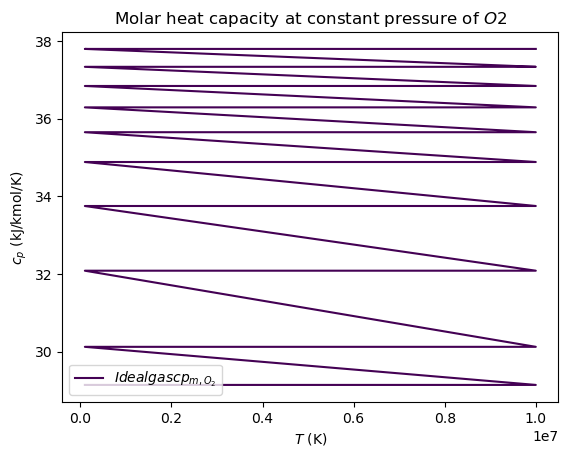

In [59]:
T_list = np.linspace(200, 2000, 10)
p_list = 1e5 * np.linspace(1, 100, 10)  # Pressure is varied from 1 to 100 bar [unit: Pa]
cp_m_O2ideal_list = []
for T in T_list:
    for p in p_list:
        gas_ideal.TP = T, p
        O2ideal = gas_ideal.species(gas_ideal.species_index('O2'))
        cp_m=O2ideal.thermo.cp(T)/1000 # kJ/kmol/K
        cp_m_O2ideal_list.append([T, p, cp_m])
        
results = np.array(cp_m_O2ideal_list)
plt.plot(results[:, 1], results[:, 2], label='$Idealgas cp_{m,O_2}$')
plt.xlabel('$T$ (K)')
plt.ylabel('$c_p$ (kJ/kmol/K)')
plt.title('Molar heat capacity at constant pressure of $O2$')
plt.legend()

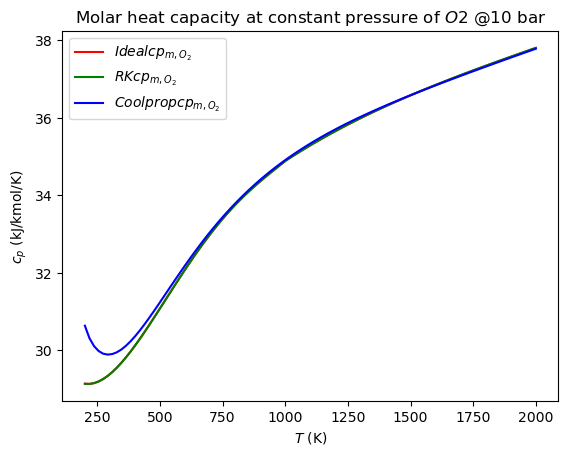

In [70]:
gas_ideal = ct.Solution('gri30.yaml',thermo='ideal-gas')
gas_RK = ct.Solution('gri30.yaml',thermo='R-K')
gas_ideal.TP = 300,1013250
gas_RK.TP = 300,1013250
O2_ideal = gas_ideal.species(gas_ideal.species_index('O2'))
O2_RK = gas_RK.species(gas_RK.species_index('O2'))

T_list = np.linspace(200, 2000, 100)
cp_ideal_list = []
cp_RK_list = []
cp_CoolProp_list = []

for T in T_list:
    cp_m=O2_ideal.thermo.cp(T)/1000 # kJ/kmol/K
    cp_ideal_list.append(cp_m)
    
    cp_m=O2_RK.thermo.cp(T)/1000 # kJ/kmol/K
    cp_RK_list.append(cp_m)

    cp_CoolProp = PropsSI("CPMOLAR", "P", 1013250, "T", T, "O2")
    cp_CoolProp_list.append(cp_CoolProp)

#Plot the results
plt.plot(T_list,cp_ideal_list, label='$Ideal cp_{m,O_2}$', color = 'r')
plt.plot(T_list,cp_RK_list, label='$RK cp_{m,O_2}$', color = 'g')
plt.plot(T_list,cp_CoolProp_list, label='$Coolprop cp_{m,O_2}$', color = 'b')
plt.xlabel('$T$ (K)')
plt.ylabel('$c_p$ (kJ/kmol/K)')
plt.title('Molar heat capacity at constant pressure of $O2$ @10 bar')
plt.legend()

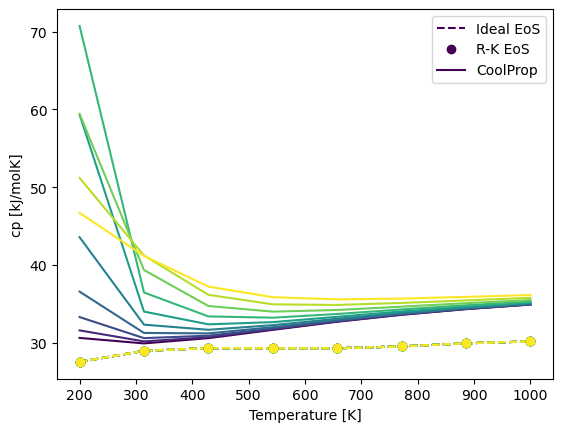

In [73]:
# Input parameters
# Set up arrays for pressure and temperature
p_array = np.logspace(1, np.log10(600), 10, endpoint=True)
T_array = np.linspace(200, 1000, 8)  # Temperature is varied from 200K to 400K
p_array = 1e5 * np.array(p_array)[:, np.newaxis]

# Calculate cp for Ideal gas
ideal_gas_phase = ct.Solution('gri30.yaml',thermo='ideal-gas')
states = ct.SolutionArray(ideal_gas_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
cp_ideal = states.cp_mole / 1000

#cp for R-K EOS
redlich_kwong_phase = ct.Solution('gri30.yaml',thermo='R-K')
states = ct.SolutionArray(redlich_kwong_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
cp_RK = states.cp_mole / 1000

#cp in CoolProp
p, T = np.meshgrid(p_array, T_array)
cp_coolprop = PropsSI("CPMOLAR", "P", np.ravel(p), "T", np.ravel(T), "O2")
cp_coolprop = cp_coolprop.reshape(p.shape)

# Plot using cycler
import cycler
color = plt.cm.viridis(np.linspace(0, 1, p_array.size))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
fig, ax = plt.subplots()
ideal_line = ax.plot(T_array, cp_ideal.T, "--", label="Ideal EoS")
RK_line = ax.plot(T_array, cp_RK.T, "o", label="R-K EoS")
CP_line = ax.plot(T_array, cp_coolprop, "-", label="CoolProp")
ax.set_ylabel("cp [kJ/molK]")
ax.set_xlabel("Temperature [K]")
ax.legend(handles=[ideal_line[0], RK_line[0], CP_line[0]])

In [13]:
#We again feed the Temperature & Pressure into our Object
gas.TP = 300,101325

#composite phase Objects need to specify which Fluid we're working with
O2 = gas.species(gas.species_index('O2'))

# Then perform the Calculations for that single Fluid
O2.thermo.cp (300) / 1000 # kJ/kmol/K

29.388071132483976

CoolProp handles input and output at once, so the PropsSI function for the above example would look like this:

In [78]:
PropsSI("CPMOLAR", "P", 101325, "T", 300, "O2")
#We query the specific molar heat at constant pressure "CPMOLAR",
#at a Pressure "P" of 101325 Pa and Temperature "T" of 300K for the species "O2"

29.435286558400477

The slight differences in values are due to the different pure fluid EOS used for each example \
For pure fluid Oxygen in Cantera see "Thermodynamic Properties in Si" by W.C. Reynolds, 1979, ISBN: 9780917606052 \
For gri30.yaml see http://combustion.berkeley.edu/gri-mech/version30/text30.html \
And for pure Oxygen in CoolProp, see https://doi.org/10.1016/0378-3812(85)87016-3 & https://doi.org/10.1063/1.555897

Once the Values are Obtained, plotting them can all be done within Cantera:

In [15]:
T_start = 200
T_end = 2000
T_list = np.linspace(T_start, T_end, 100)
cp_m_O2Pure_list = []
cp_m_O2Composite_list = []
cp_m_O2CoolProp_list = []

#PureFluid O2
for T in T_list:
    oxygen.TP = T,101325
    cp_m=oxygen.cp_mole/1000 # kJ/kmol/K
    cp_m_O2Pure_list.append(cp_m)

#Composite Phase Object O2
for T in T_list:
    cp_m=O2.thermo.cp(T)/1000 # kJ/kmol/K
    cp_m_O2Composite_list.append(cp_m)

#Collprop O2
for T in T_list:
    cp_m=PropsSI("CPMOLAR", "P", 101325, "T", T, "O2") # kJ/kmol/K
    cp_m_O2CoolProp_list.append(cp_m)


print(T_list)

[ 200.          218.18181818  236.36363636  254.54545455  272.72727273
  290.90909091  309.09090909  327.27272727  345.45454545  363.63636364
  381.81818182  400.          418.18181818  436.36363636  454.54545455
  472.72727273  490.90909091  509.09090909  527.27272727  545.45454545
  563.63636364  581.81818182  600.          618.18181818  636.36363636
  654.54545455  672.72727273  690.90909091  709.09090909  727.27272727
  745.45454545  763.63636364  781.81818182  800.          818.18181818
  836.36363636  854.54545455  872.72727273  890.90909091  909.09090909
  927.27272727  945.45454545  963.63636364  981.81818182 1000.
 1018.18181818 1036.36363636 1054.54545455 1072.72727273 1090.90909091
 1109.09090909 1127.27272727 1145.45454545 1163.63636364 1181.81818182
 1200.         1218.18181818 1236.36363636 1254.54545455 1272.72727273
 1290.90909091 1309.09090909 1327.27272727 1345.45454545 1363.63636364
 1381.81818182 1400.         1418.18181818 1436.36363636 1454.54545455
 1472.72727273

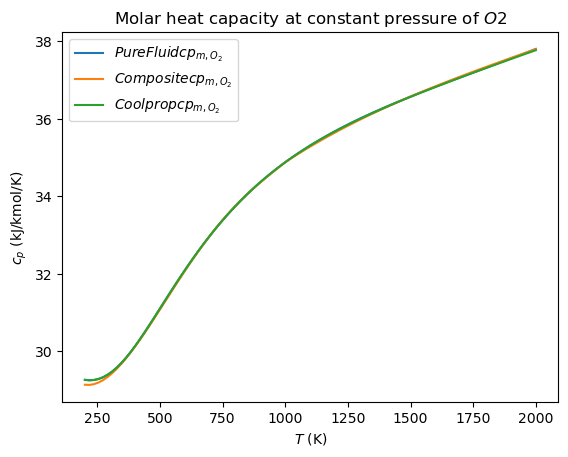

In [16]:
#Plot the results
plt.plot(T_list,cp_m_O2Pure_list, label='$PureFluid cp_{m,O_2}$')
plt.plot(T_list,cp_m_O2Composite_list, label='$Composite cp_{m,O_2}$')
plt.plot(T_list,cp_m_O2CoolProp_list, label='$Coolprop cp_{m,O_2}$')
plt.xlabel('$T$ (K)')
plt.ylabel('$c_p$ (kJ/kmol/K)')
plt.title('Molar heat capacity at constant pressure of $O2$')
plt.legend()